# Análisis de los Datos del Corán

Este notebook contiene un análisis exploratorio de los datos del proyecto, incluyendo estadísticas descriptivas y visualizaciones para el Corán en árabe e inglés necesarias para la primera entrega del proyecto.

## Libererías necesarias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")

## Empecemos!

Aqui cargamos el coran normalizado para evitar posibles ambiguedades

In [2]:
ar_q = pd.read_csv("../data/cleaned_data/cleaned_arab_quran.txt", 
                    sep="|", 
                    names=["Capítulo", "Versículo", "Texto"],
                    engine="python",
                    header=None)
ar_q["Capítulo"] = pd.to_numeric(ar_q["Capítulo"], errors="coerce")
ar_q.head()

,Capítulo,Versículo,Texto
0,1.0,1.0,بسم الله الرحمن الرحيم
1,1.0,2.0,الحمد لله رب العالمين
2,1.0,3.0,الرحمن الرحيم
3,1.0,4.0,مالك يوم الدين
4,1.0,5.0,اياك نعبد واياك نستعين


Estadísticas básicas

In [3]:
# Simplemente para ver el número de versos sin tener que eliminar los derechos de autor del dataset original
n_versos = len(ar_q["Texto"])
print(f"Número de versos antes de limpiar: {n_versos}")


ar_q = ar_q.dropna(subset=['Texto'])
ar_q = ar_q[ar_q['Texto'].str.strip() != '']

n_versos = len(ar_q["Texto"])
print(f"Número de versos después de limpiar: {n_versos}")

Número de versos antes de limpiar: 6264
Número de versos después de limpiar: 6236


In [4]:
n_capitulos = ar_q["Capítulo"].nunique()

print(f"Número de versos del Corán: {n_versos}.")
print(f"Número de capítulos del Corán: {n_capitulos}.")

ar_q["Número de palabras del verso"] = ar_q["Texto"].str.split().apply(lambda x: len(x) if isinstance(x, list) else 0)

n_palabras = ar_q["Número de palabras del verso"].sum()
promedio_palabras = ar_q["Número de palabras del verso"].mean()

print(f"Número total de palabras: {n_palabras}.")
print(f"Número promedio de palabras por verso: {round(promedio_palabras, 0)}.")

Número de versos del Corán: 6236.
Número de capítulos del Corán: 114.
Número total de palabras: 82627.
Número promedio de palabras por verso: 13.0.


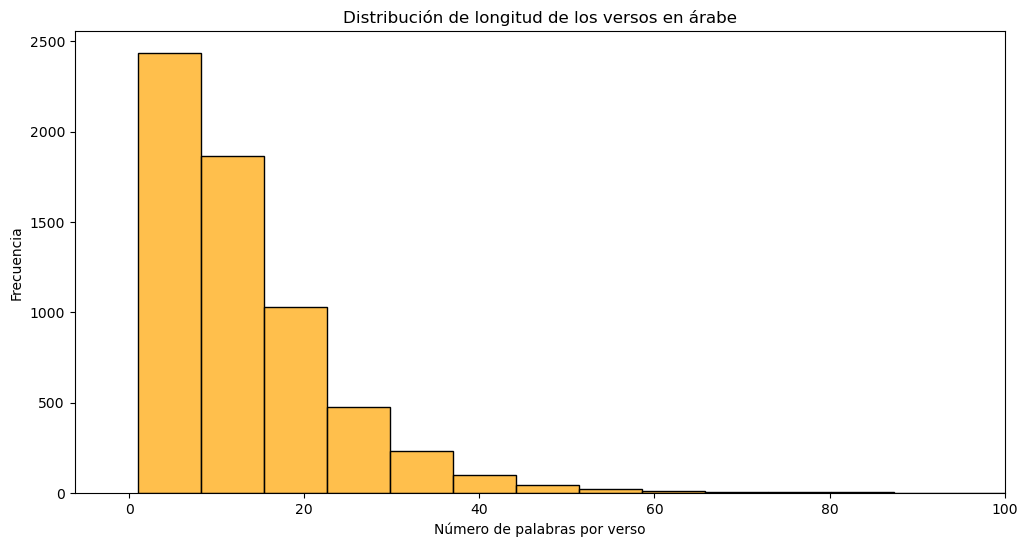

In [5]:
plt.figure(figsize=(12,6))
sns.histplot(ar_q["Número de palabras del verso"], bins=20, color="orange", alpha=.7)
plt.xlim(right=100)
plt.xlabel("Número de palabras por verso")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitud de los versos en árabe")
plt.show()

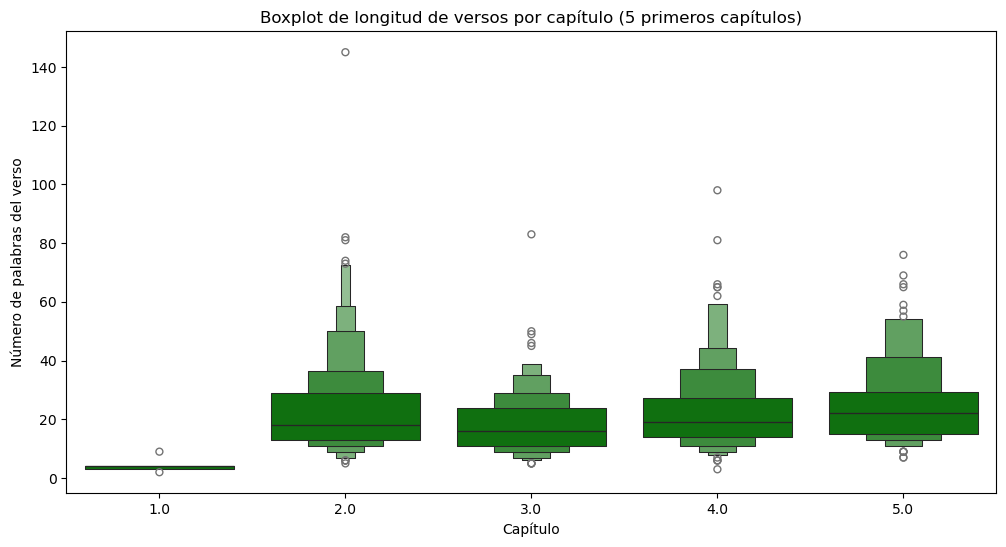

In [6]:
plt.figure(figsize=(12,6))
sns.boxenplot(x="Capítulo", y="Número de palabras del verso", data=ar_q[ar_q["Capítulo"] <= 5], color="green")
plt.title("Boxplot de longitud de versos por capítulo (5 primeros capítulos)")
plt.show()

## Camel_tools

Vamos a jugar un poco con camel_tools, una librería que hemos encontrado por chiripa y parece muy interesante.

Tareas:
- Probar a taggear las palabras y ver cuántas hay de cada una
- Mostrar las 10 palabras más comunes en árabe

A ver qué nos ofrece (https://camel-tools.readthedocs.io/en/latest/index.html)

In [40]:
from camel_tools.tokenizers.word import simple_word_tokenize

texto = ar_q["Texto"].tolist()

def remove_stopwords_ar(texto):
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('arabic'))

    tokens = []
    for sentence in texto:
        tokens.extend(simple_word_tokenize(sentence))

    clean_tokens = [tok for tok in tokens if tok not in stop_words]
    
    return clean_tokens

tokens = remove_stopwords_ar(texto)

## Analyzer (ya implicito) + BERT disambiguator

Aquí lo que nos interesa es descargar el morphological analyzer para analizar las palabras (que aunque no se llame a ninguna función suya el disambiguator lo usa por dentro) y el disambiguator para eliminar posibles ambigüedades en el significado.

In [8]:
#instalamos los modelos necesarios
!camel_data --install morphology-db-msa-r13
!camel_data --install disambig-bert-unfactored-msa

No new packages will be installed.
No new packages will be installed.
No new packages will be installed.


In [9]:
from camel_tools.disambig.bert import BERTUnfactoredDisambiguator
from camel_tools.tagger.default import DefaultTagger

## Disambiguator

El disambiguator lo que hace es sacar el significado real de palabras que pueden tener más de un significado ya sea por polisemia o por la complejidad lexica del árabe.

In [ ]:
batch_size = 2048

disambig = BERTUnfactoredDisambiguator.pretrained(use_gpu=True)
print(len(tokens))

def disambiguate_tokens(tokens, disambig, batch_size):
    disambig_words = []
    for i in range(0, len(tokens), batch_size):
        batch = tokens[i:i+batch_size]
        disambig_words.extend(disambig.disambiguate(batch))

    print(len(disambig_words))
    for d in disambig_words[:5]:
        best = d.analyses[0].analysis
        print(d.word, "→", best['lex'], "| POS:", best['pos'], "| Gloss:", best.get('gloss'))

    return disambig_words

disambig_words = disambiguate_tokens(tokens, disambig, batch_size)

Some weights of the model checkpoint at C:\Users\diego\AppData\Roaming\camel_tools\data\disambig_bert_unfactored\msa were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


67176
67176
بسم → سَمّ | POS: noun | Gloss: by;with+poison+[def.gen.]
الله → اللَّه | POS: noun_prop | Gloss: Allah;God
الرحمن → رَحْمٰن | POS: adj | Gloss: the+merciful+[def.nom.]
الرحيم → رَحِيم | POS: adj | Gloss: the+compassionate+[def.nom.]
الحمد → حَمْد | POS: noun | Gloss: the+commendation;praise+[def.nom.]
67176
بسم → سَمّ | POS: noun | Gloss: by;with+poison+[def.gen.]
الله → اللَّه | POS: noun_prop | Gloss: Allah;God
الرحمن → رَحْمٰن | POS: adj | Gloss: the+merciful+[def.nom.]
الرحيم → رَحِيم | POS: adj | Gloss: the+compassionate+[def.nom.]
الحمد → حَمْد | POS: noun | Gloss: the+commendation;praise+[def.nom.]


## Pasos finales

Ahora guardamos los tokens ya desambigüados, normalizados, lematizados y sin stop words en la variable norm_tok ya que al coger la clave 'lex' del diccionario estaríamos obteniendo el lema o también conocido como la forma canónica del diccionario.

Ejemplo:
- "كَتَبَ", "كُتُب", "بالكتاب" → todos van a lex = "كتاب".

Y por otro lado en gloss_tok estamos guardando la glosa en ingles, que sería una traducción aproximada al inglés del árabe.

Con esto lo que finalmente tenemos es:
- No stop words
- Tokens normalizados y lematizados
- Tokens desambigüados
- Significado aproximado del token en inglés

In [11]:
norm_tok = [d.analyses[0].analysis['lex'] for d in disambig_words]
print(norm_tok[:10])
gloss_tok = [d.analyses[0].analysis['gloss'] for d in disambig_words]
print(gloss_tok[:10])

['سَمّ', 'اللَّه', 'رَحْمٰن', 'رَحِيم', 'حَمْد', 'اللَّه', 'رَبّ', 'عالَم', 'رَحْمٰن', 'رَحِيم']
['by;with+poison+[def.gen.]', 'Allah;God', 'the+merciful+[def.nom.]', 'the+compassionate+[def.nom.]', 'the+commendation;praise+[def.nom.]', 'to;for_God;Allah', 'lord;master+[def.nom.]', 'the+worlds+[masc.pl.]', 'the+merciful+[def.nom.]', 'the+compassionate+[def.nom.]']


## POS tagger

Aquí lo que hacemos es etiquetar gramaticalmente las palabras del Corán

In [12]:
pos_tagger = DefaultTagger(disambig, feature='pos')
pos_tags = pos_tagger.tag(norm_tok)

In [13]:
from collections import Counter
conteo = Counter(pos_tags)
print(conteo.most_common(10))

[('noun', 4637), ('verb', 3008), ('noun_prop', 1861), ('foreign', 1112), ('prep', 675), ('conj_sub', 623), ('adj', 616), ('conj', 251), ('part', 120), ('pron_rel', 103)]


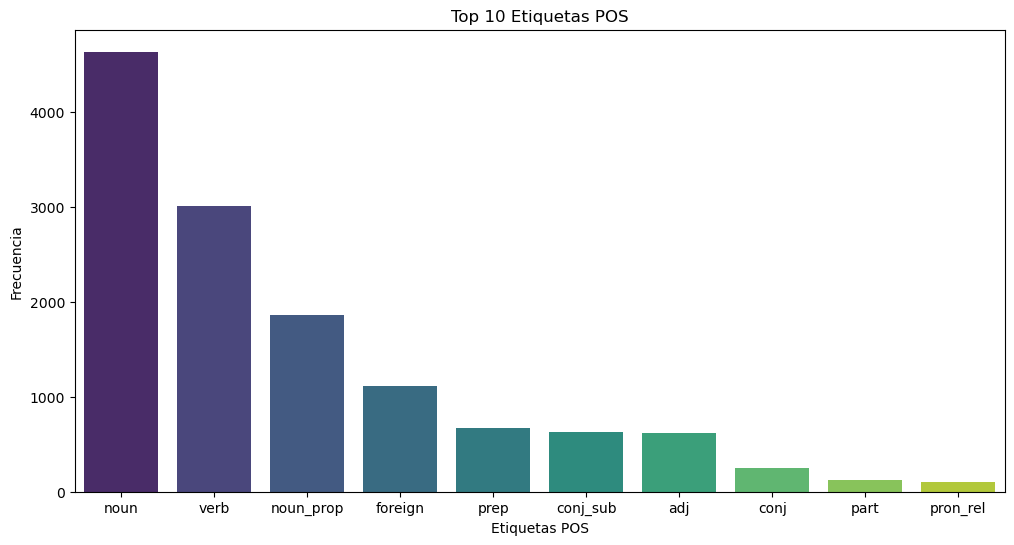

In [14]:
#Ploteamos las 10 etiquetas más comunes
plt.figure(figsize=(12,6))
etiquetas = [x[0] for x in conteo.most_common(10)]
frecuencias = [x[1] for x in conteo.most_common(10)]
sns.barplot(x=list(etiquetas), y=list(frecuencias), palette="viridis")
plt.xlabel("Etiquetas POS")
plt.ylabel("Frecuencia")
plt.title("Top 10 Etiquetas POS")
plt.show()

## Conteo de palabras

In [15]:
contar_palabras_arab = Counter(norm_tok)
contar_palabras_eng_gloss = Counter(gloss_tok)
print(contar_palabras_arab.most_common(10))
print(contar_palabras_eng_gloss.most_common(10))

[('أَنَّ', 2836), ('اللَّه', 2661), ('ۚ', 1972), ('ۖ', 1682), ('قال', 1480), ('عَلَى', 1239), ('كان', 1120), ('رَبّ', 954), ('إِلَى', 722), ('إِلّا', 703)]
[('NO_ANALYSIS', 2939), ('Allah;God', 2267), ('ۚ', 1972), ('that', 1696), ('ۖ', 1682), ('however;except', 702), ('on;above', 677), ('ۗ', 603), ('said+he;it_<verb>', 416), ('or', 402)]


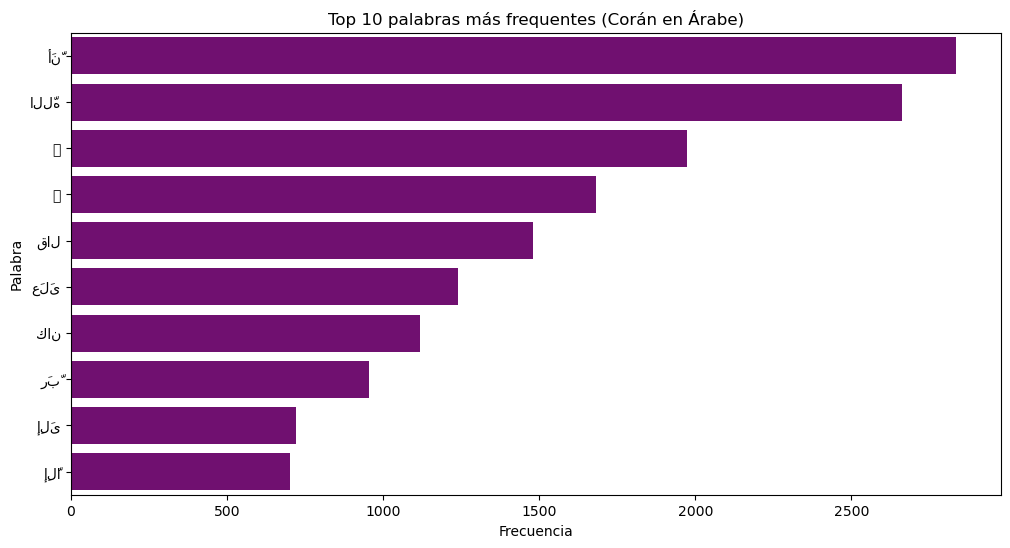

In [16]:
top10 = contar_palabras_arab.most_common(10)
palabras, frequencias = zip(*top10)

plt.figure(figsize=(12,6))
sns.barplot(x=list(frequencias), y=list(palabras), color="purple")
plt.title("Top 10 palabras más frequentes (Corán en Árabe)")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()

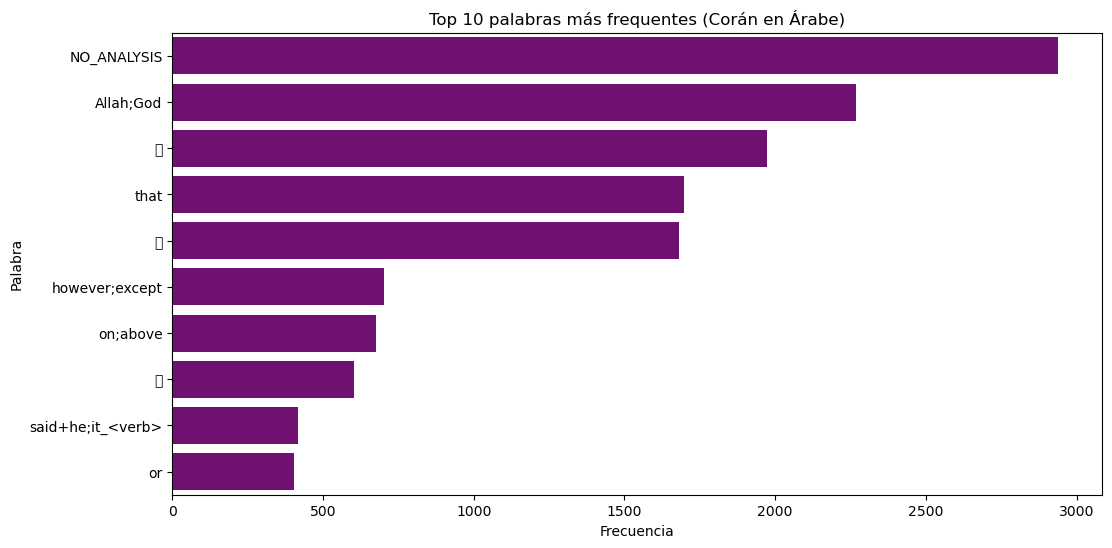

In [17]:
top10 = contar_palabras_eng_gloss.most_common(10)
palabras, frequencias = zip(*top10)

plt.figure(figsize=(12,6))
sns.barplot(x=list(frequencias), y=list(palabras), color="purple")
plt.title("Top 10 palabras más frequentes (Corán en Árabe)")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()

Como vemos arriba tenemos un problema con las stopwords en árabe y la limpieza de estas. Hay muchas stopwords en inglés que siguen apareciendo ya que las glosas no las filtran. También encontramos palabras que tienen NO_ANALYSIS que significa que el desambigüador no devolvió un análisis. Además hay otras etiquetas con signos de puntuación que hay que normalizar.

In [18]:
import re

en_stop_words = set(stopwords.words('english'))

def canon_gloss(g: str | None):
    if not g: 
        return None
    g = g.split(";")[0]
    g = g.split("+")[0]
    g = re.sub(r"\[.*?\]|\<.*?\>", "", g)
    g = g.strip().lower()
    # deja solo letras/espacios para evitar signos raros
    g = re.sub(r"[^a-z\s]", "", g).strip()
    return g or None

def cleaning(disambig_words):
    rows = []
    no_analysis = 0
    for dw in disambig_words:
        if not dw.analyses or dw.analyses[0].analysis.get("gloss") == "NO_ANALYSIS":
            no_analysis += 1
            continue
        best = dw.analyses[0].analysis
        if best.get("pos") == "punc":
            continue
        gloss = canon_gloss(best.get("gloss"))
        if not gloss:
            continue
        if gloss in en_stop_words:
            continue
        rows.append(gloss)
    return rows, no_analysis

print("NO_ANALYSIS descartados:", cleaning(disambig_words)[1])
freq_gloss = Counter(cleaning(disambig_words)[0])
top10_gloss = freq_gloss.most_common(10)
top10_gloss

NO_ANALYSIS descartados: 2939


[('allah', 2267),
 ('theypeople', 1738),
 ('lord', 881),
 ('said', 730),
 ('however', 706),
 ('arrive', 361),
 ('insure', 309),
 ('say', 273),
 ('something', 267),
 ('day', 246)]

Volvemos a probar a plotear a ver qué sale.

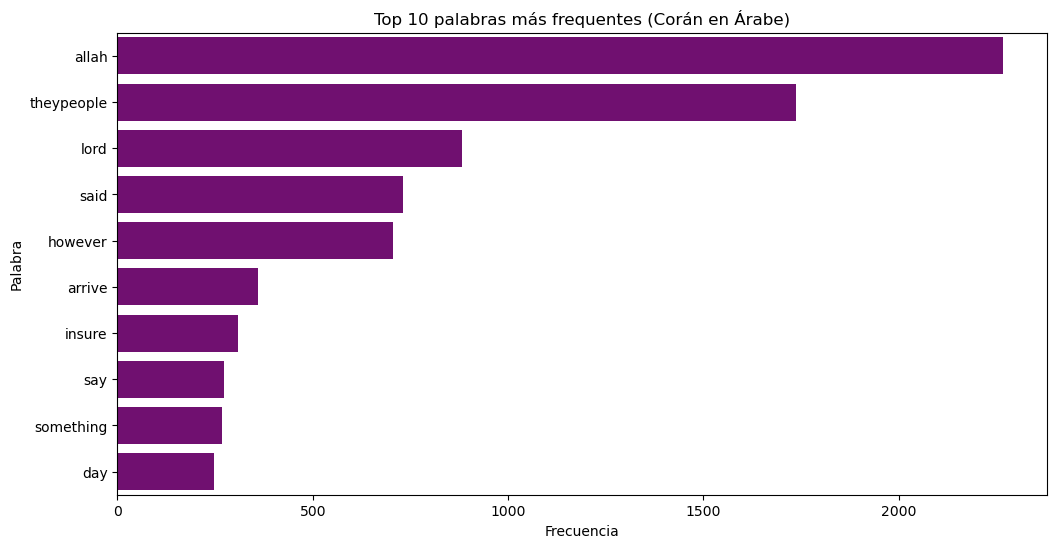

In [19]:
top10_gloss = freq_gloss.most_common(10)
palabras, frequencias = zip(*top10_gloss)

plt.figure(figsize=(12,6))
sns.barplot(x=list(frequencias), y=list(palabras), color="purple")
plt.title("Top 10 palabras más frequentes (Corán en Árabe)")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()

Ahora vamos a hacer exactamente lo que hemos hecho con el árabe pero en inglés para comparar si efectivamente el disambiguator y todo funciona correctamente.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


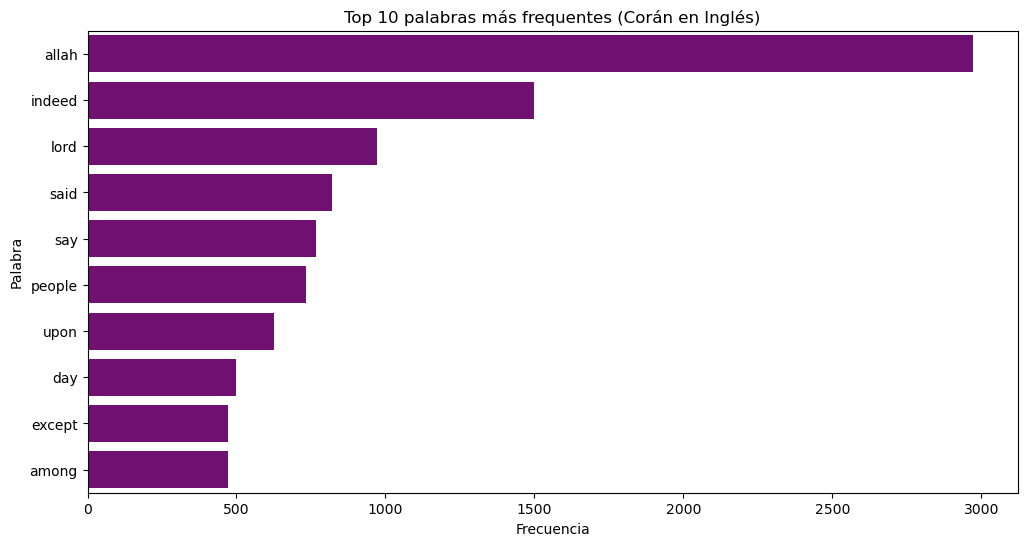

In [20]:
eng_q = pd.read_csv('../data/raw_data/english_quran.txt', 
                    sep="|", 
                    names=["Capítulo", "Verso", "Texto"],
                    engine="python",
                    quoting=3, # Necesario para evitar problemas con las comillas en el texto en inglés.
                    header=None)
eng_q["Capítulo"] = pd.to_numeric(eng_q["Capítulo"], errors="coerce")
eng_q.head()

palabras = " ".join(eng_q["Texto"].dropna()).split()

# Para una representación más filedigna, vamos a obviar los stopwords
nltk.download("stopwords")
stopwords_eng = set(stopwords.words("english"))

palabras_sin_sw = [
    p.lower().strip(string.punctuation)  # quita comas, puntos, ... 
    for p in eng_q["Texto"].dropna().str.split().sum()
    if p.lower().strip(string.punctuation) not in stopwords_eng and p.lower().strip(string.punctuation) != ""
]
frequencia_palabra = Counter(palabras_sin_sw)

top10 = frequencia_palabra.most_common(10)

palabras, frequencias = zip(*top10)

plt.figure(figsize=(12,6))
sns.barplot(x=list(frequencias), y=list(palabras), color="purple")
plt.title("Top 10 palabras más frequentes (Corán en Inglés)")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()

Parece que si, las primeras 10 palabras mas comunes coinciden casi en su totalidad. Asi que podemos concluir que hemos limpiado correctamente el texto en árabe de manera que se puede traducir bastante bien y que los metodos de desambiguación, tokenización y normalización efectivamente funcionan.

## TF - IDF (Update de la entrega 2) 
Por último, vamos a probar el método TF-IDF para estudiar más a fondo el análisis de las palabras. Haremos plot de las 10 palabras en cada idioma con mayor valor en el término TF-IDF.

In [72]:
vectorizer_ar = TfidfVectorizer(lowercase=False,
                                max_df=.85, # ignorar palabras que aparecen en más del 85% de los documentos
                                min_df=2, # ignorar palabras que aparecen en menos de 2 documentos
                                ngram_range=(1,1), # sólo queremos unigramas
                                max_features=10000)
vectorizer_eng = TfidfVectorizer(lowercase=True,
                                 stop_words='english', # en inglés sí que existe la opción de eliminar stopwords
                                 max_df=.85,
                                 min_df=2,
                                 ngram_range=(1,1),
                                 max_features=10000)

# construimos el corpus por capítulos (documento = Capítulo)
ar_docs = (
    ar_q.dropna(subset=["Texto"]) 
        .groupby(["Capítulo"], sort=True, as_index=False)["Texto"]
        .agg(lambda s: " ".join(map(str, s))) # esta linea une todos los versos y versiculos de un capítulo en un solo string
)
eng_docs = (
    eng_q.dropna(subset=["Texto"]) 
         .groupby(["Capítulo"], sort=True, as_index=False)["Texto"]
         .agg(lambda s: " ".join(map(str, s)))
)
print(f"Capítulos árabe (docs): {len(ar_docs)} | capítulos inglés (docs): {len(eng_docs)}")

# vectorizamos por capítulo
a_docs_text = ar_docs["Texto"]
e_docs_text = eng_docs["Texto"]
X_ar = vectorizer_ar.fit_transform(a_docs_text)
X_eng = vectorizer_eng.fit_transform(e_docs_text)

print(X_ar)

Capítulos árabe (docs): 114 | capítulos inglés (docs): 114
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 32503 stored elements and shape (114, 5551)>
  Coords	Values
  (0, 564)	0.22129102960963734
  (0, 3599)	0.16067736940030553
  (0, 2214)	0.1535470301526985
  (0, 718)	0.2037892287841073
  (0, 3700)	0.3571781876475942
  (0, 5543)	0.12621832456287813
  (0, 600)	0.1842521114973112
  (0, 4087)	0.3113192373085823
  (0, 688)	0.3113192373085823
  (0, 866)	0.3239514548466245
  (0, 2527)	0.21747884429828085
  (0, 608)	0.11697504895130342
  (0, 1078)	0.3239514548466245
  (0, 2743)	0.2625256438213847
  (0, 2811)	0.1771217722497042
  (0, 4807)	0.11271709351362291
  (0, 695)	0.3239514548466245
  (1, 3599)	0.04590601932663793
  (1, 2214)	0.007311476573672185
  (1, 718)	0.01940773677927806
  (1, 5543)	0.015025401700897332
  (1, 600)	0.013160348938587571
  (1, 4087)	0.007412072080624311
  (1, 2527)	0.010355729275746179
  (1, 608)	0.203305801603778
  :	:
  (111, 3623)	0.16161457364536

In [100]:
df_tfidf_ar = pd.DataFrame(
    X_ar.toarray(),
    columns=vectorizer_ar.get_feature_names_out()
)

df_tfidf_en = pd.DataFrame(
    X_eng.toarray(),
    columns=vectorizer_eng.get_feature_names_out()
)

print(df_tfidf_ar.shape)
print(df_tfidf_ar.head())

# Voy a probar un truco un poco sucio para eliminar las stopwords en árabe
different_words = df_tfidf_ar.columns.tolist()
print(len(different_words))

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('arabic'))
diff_words = [tok for tok in different_words if tok not in stop_words]
print(len(diff_words))

#vamos a intentar eliminar las columnas que sean stopwords
columnas_a_eliminar = [col for col in df_tfidf_ar.columns if col not in diff_words]
df_filtrado = df_tfidf_ar.drop(columns=columnas_a_eliminar)
print(len(df_filtrado.columns))

(114, 5551)
   ائت  ائتنا  ائتوا  ائتوني  ائمه  ائن  ائنا  ائنكم  ااذا  اانا  ...  \
0  0.0    0.0    0.0     0.0   0.0  0.0   0.0    0.0   0.0   0.0  ...   
1  0.0    0.0    0.0     0.0   0.0  0.0   0.0    0.0   0.0   0.0  ...   
2  0.0    0.0    0.0     0.0   0.0  0.0   0.0    0.0   0.0   0.0  ...   
3  0.0    0.0    0.0     0.0   0.0  0.0   0.0    0.0   0.0   0.0  ...   
4  0.0    0.0    0.0     0.0   0.0  0.0   0.0    0.0   0.0   0.0  ...   

     يوقنون  يولج       يوم     يومئذ      يوما  يومكم  يومهم     يومين  يونس  \
0  0.000000   0.0  0.126218  0.000000  0.000000    0.0    0.0  0.000000   0.0   
1  0.013843   0.0  0.015025  0.000000  0.025442    0.0    0.0  0.009065   0.0   
2  0.000000   0.0  0.048461  0.006630  0.000000    0.0    0.0  0.000000   0.0   
3  0.000000   0.0  0.012637  0.005763  0.000000    0.0    0.0  0.000000   0.0   
4  0.013134   0.0  0.028511  0.000000  0.000000    0.0    0.0  0.000000   0.0   

   يياس  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  

[

Ahora crearemos una función para escoger las 10 palabras com mayor TF-IDF:

In [ ]:
def top_10_TFIDF(df_tfidf):
    """
    Calcula las 10 palabras con mayor TF-IDF promedio en el corpus
    a partir de un DataFrame (documentos x palabras)
    """
    # Promedio TF-IDF por palabra (columna)
    suma_documentos = df_tfidf.sum(axis=0) / df_tfidf.shape[0]

    # Convertir a DataFrame con columnas 'palabra' y 'tfidf'
    df = pd.DataFrame({
        "palabra": suma_documentos.index,
        "tfidf": suma_documentos.values
    })

    # Ordenar y devolver las 10 más altas
    return df.sort_values(by="tfidf", ascending=False).head(10)

top_10_ar = top_10_TFIDF(df_tfidf_ar)
top_10_eng = top_10_TFIDF(df_tfidf_en)

#aqui obtenemos la palabra con mayor tfidf por documento
word_doc = {}
word_doc["word"] = df_tfidf_ar.idxmax(axis=1)
word_doc["value"] = df_tfidf_ar.max(axis=1)

word_doc_df = pd.DataFrame(word_doc)
print(word_doc_df.head())

    word     value
0   مالك  0.357178
1    ولا  0.222742
2  الذين  0.256000
3   وكان  0.207641
4  الذين  0.253658


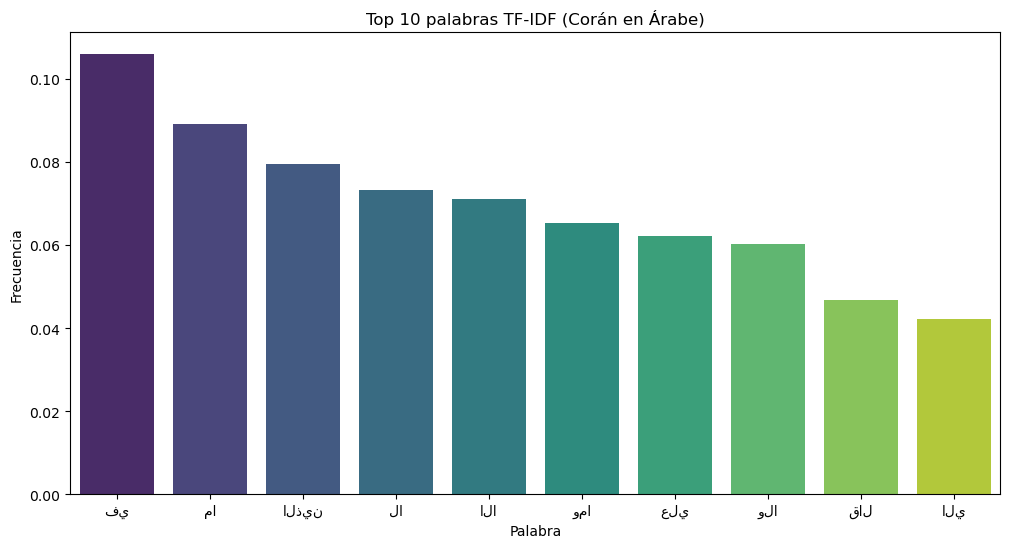

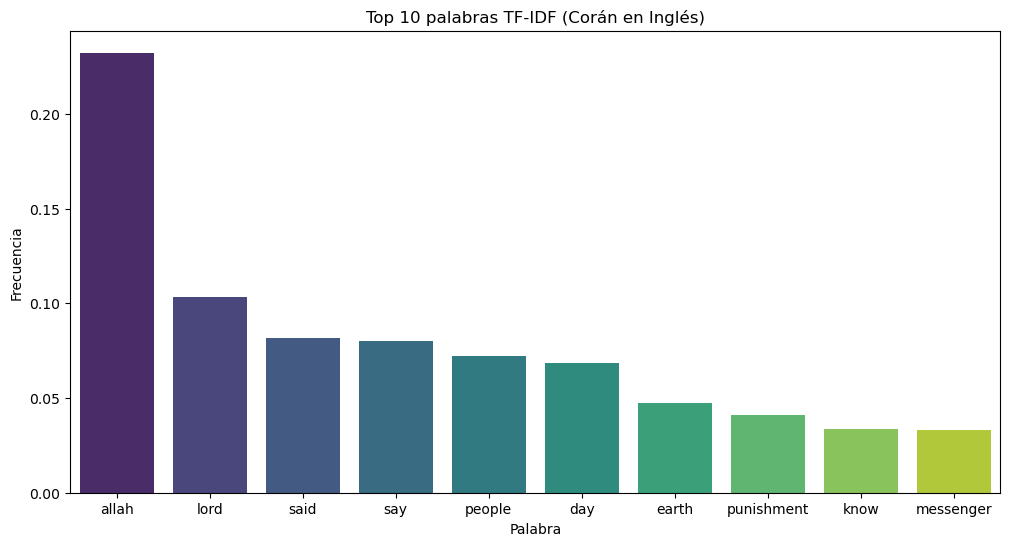

<Figure size 640x480 with 0 Axes>

In [104]:
plt.figure(figsize=(12,6))
sns.barplot(x=top_10_ar["palabra"], y=top_10_ar["tfidf"], palette="viridis")
plt.title("Top 10 palabras TF-IDF (Corán en Árabe)")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")
plt.show() 

plt.figure(figsize=(12,6))
sns.barplot(x=top_10_eng["palabra"], y=top_10_eng["tfidf"], palette="viridis")
plt.title("Top 10 palabras TF-IDF (Corán en Inglés)")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")
plt.show()

plt.tight_layout()
plt.show()

Aunque no se pueda conluir que las 10 palabras con mayor TF-IDF sean idénticas o similares en árabe y en inglés hay una correlación interesante entre los histogramas recien ploteados y los que se creaban a base de las 10 palabras más frecuentes. Esto se explicará mas detalladamente en la entrega.

Para poder traducirlas bien usaremos el proceso implementado en la anterior parte:

In [105]:
from collections import defaultdict, Counter

cands = defaultdict(list)

for dw in disambig_words:
    if not dw.analyses or dw.analyses[0].analysis.get("gloss") == "NO_ANALYSIS":
        continue
    best = dw.analyses[0].analysis
    if best.get("pos") == "punc":
        continue

    gloss = canon_gloss(best.get("gloss"))
    if not gloss:
        continue

    # CLAVE = forma de superficie, para casar con top_10_ar["palabra"]
    key = best.get('word')
    cands[key].append(gloss)

mapping_gloss = {w: Counter(gs).most_common(1)[0][0] for w, gs in cands.items()}

# Fallback opcional para partículas comunes
FALLBACK = {'و':'and','في':'in','على':'on','ما':'what/neg','لا':'not','من':'from',
            'الى':'to','إلى':'to','عن':'about','إن':'indeed/if','ال':'the'}

top_10_ar["gloss"] = [mapping_gloss.get(w) or FALLBACK.get(w) for w in top_10_ar["palabra"]]
print(top_10_ar)


     palabra     tfidf     gloss
3160      في  0.105835        in
3691      ما  0.089214  what/neg
608    الذين  0.079581      None
3410      لا  0.073151       not
431      الا  0.071002      None
4871     وما  0.065313      None
2734     علي  0.062059      None
4807     ولا  0.060267      None
3193     قال  0.046733      None
976      الي  0.042264      None


Como podemos ver arriba los `None` ya nos estan afectando debido a que BERT puede que no este cubriendo ciertas partes del lenguaje usado en el corán y por eso las deja sin analisis. Por ello, probaremos a usar otros modelos y compararemos los resultados. En caso de no encontrar nada totalmente efectivo usaremos la api de algun traductor para hacerlo efectivo.

El nuevo modelo que hemos escogido es 

In [25]:
!camel_data --install disambig-mle-calima-msa-r13
from camel_tools.disambig.mle import MLEDisambiguator

No new packages will be installed.


In [26]:
batch_size = 2048

# Maximum likelihood estimation disambiguator
disambig = MLEDisambiguator.pretrained()
print(len(tokens))

disambig_words_mle = []
for i in range(0, len(tokens), batch_size):
    batch = tokens[i:i+batch_size]
    disambig_words_mle.extend(disambig.disambiguate(batch))

print(len(disambig_words_mle))
for d in disambig_words_mle[:5]:
    best = d.analyses[0].analysis
    print(d.word, "→", best['lex'], "| POS:", best['pos'], "| Gloss:", best.get('gloss'))

67176
67176
بسم → سَمّ | POS: noun | Gloss: by;with+poison
الله → اللَّه | POS: noun_prop | Gloss: Allah;God
الرحمن → رَحْمٰن | POS: noun_prop | Gloss: the+Rahman
الرحيم → رَحِيم | POS: noun_prop | Gloss: the+Rahim
الحمد → حَمْد | POS: noun | Gloss: the+commendation;praise
67176
بسم → سَمّ | POS: noun | Gloss: by;with+poison
الله → اللَّه | POS: noun_prop | Gloss: Allah;God
الرحمن → رَحْمٰن | POS: noun_prop | Gloss: the+Rahman
الرحيم → رَحِيم | POS: noun_prop | Gloss: the+Rahim
الحمد → حَمْد | POS: noun | Gloss: the+commendation;praise


In [27]:
norm_tok_mle = [d.analyses[0].analysis['lex'] for d in disambig_words_mle]
print(norm_tok_mle[:10])
gloss_tok_mle = [d.analyses[0].analysis['gloss'] for d in disambig_words_mle]
print(gloss_tok_mle[:10])

['سَمّ', 'اللَّه', 'رَحْمٰن', 'رَحِيم', 'حَمْد', 'اللَّه', 'رَبّ', 'عالَم', 'رَحْمٰن', 'رَحِيم']
['by;with+poison', 'Allah;God', 'the+Rahman', 'the+Rahim', 'the+commendation;praise', 'to;for_God;Allah', 'owner;proprietor+[def.gen.]', 'the+world+two', 'the+Rahman', 'the+Rahim']


In [28]:
contar_palabras_arab_mle = Counter(norm_tok_mle)
contar_palabras_eng_gloss_mle = Counter(gloss_tok_mle)
print(contar_palabras_arab_mle.most_common(10))
print(contar_palabras_eng_gloss_mle.most_common(10))

[('اللَّه', 2801), ('أَنَّ', 2607), ('ۚ', 1972), ('ۖ', 1682), ('قال', 1590), ('عَلَى', 1206), ('كان', 1165), ('رَبّ', 971), ('مِن', 765), ('إِلّا', 765)]
[('Allah;God', 2267), ('ۚ', 1972), ('that', 1696), ('ۖ', 1682), ('NO_ANALYSIS', 1636), ('however;except', 763), ('on;above', 686), ('ۗ', 603), ('to;towards', 430), ('said+he;it_<verb>', 416)]


In [29]:
print(ar_q["Texto"].iloc[:20])
print(len(ar_q["Texto"]))

0                                بسم الله الرحمن الرحيم
1                                 الحمد لله رب العالمين
2                                         الرحمن الرحيم
3                                        مالك يوم الدين
4                                اياك نعبد واياك نستعين
5                                 اهدنا الصراط المستقيم
6     صراط الذين انعمت عليهم غير المغضوب عليهم ولا ا...
7                            بسم الله الرحمن الرحيم الم
8                 ذلك الكتاب لا ريب ۛ فيه ۛ هدي للمتقين
9     الذين يؤمنون بالغيب ويقيمون الصلاه ومما رزقناه...
10    والذين يؤمنون بما انزل اليك وما انزل من قبلك و...
11           اولئك علي هدي من ربهم ۖ واولئك هم المفلحون
12    ان الذين كفروا سواء عليهم اانذرتهم ام لم تنذره...
13    ختم الله علي قلوبهم وعلي سمعهم ۖ وعلي ابصارهم ...
14    ومن الناس من يقول امنا بالله وباليوم الاخر وما...
15    يخادعون الله والذين امنوا وما يخدعون الا انفسه...
16    في قلوبهم مرض فزادهم الله مرضا ۖ ولهم عذاب الي...
17    واذا قيل لهم لا تفسدوا في الارض قالوا انما

BERTUnfactored: modelo neuronal contextual (basado en CAMeLBERT), aprende de grandes corpus y usa el contexto de toda la oración. 
camel-tools.readthedocs.io

MLE: tabla MLE por palabra + analizador con probabilidades pos-lex; principalmente fuera de contexto.

ideas:

- Hacer topic vectors y poder clasificar los documentos en diferentes topics (e intentar hacerlos comprensibles)
- terminar de hacer el traductor bien
- extraer conclusiones entre los tfidf y las 10 palabras mas comunes que extraiamos previamente
- es interesante ver que podemos conseguir de saber cual es la palabra o palabras mas significativas por documento